In [43]:
%pip install opencv-python torch torchvision torchaudio paho-mqtt ultralyticsplus ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [44]:
import json
import time
import cv2
import numpy as np
import paho.mqtt.client as mqtt 
from ultralyticsplus import YOLO, render_result
from datetime import datetime
from IPython.display import display, Image as IPImage, clear_output
import ipywidgets as widgets
import torch

print("All libraries imported successfully!")

All libraries imported successfully!


### configuration mqtt 

In [45]:
# model 
MODEL_ID = "lewiswatson/yolov8x-tuned-hand-gestures"
CONF = 0.45 

# MQTT 
MQTT_BROKER = "broker.hivemq.com" 
MQTT_PORT = 1883
MQTT_TOPIC = "hand/gesture"  # Plain text payload 
MQTT_TOPIC_RAW = "hand/gesture/raw"    # full json payload
PUB_DELAY = 0.3 
DEVICE = 'cuda' 
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

# 0          = Default Webcam
# 1, 2, ...  = Other camera index
# "path/to/image.jpg" = Static image
# "path/to/video.mp4" = Video file

print(f"MQTT  : {MQTT_BROKER}:{MQTT_PORT}")
print(f"Topics: {MQTT_TOPIC}  |  {MQTT_TOPIC_RAW}")
print(f"Conf  : {CONF}")

MQTT  : broker.hivemq.com:1883
Topics: hand/gesture  |  hand/gesture/raw
Conf  : 0.45


###### MQTT publish class

In [46]:
class MQTTPub:
    def __init__(self, broker: str, port: int):
        self.broker = broker
        self.port = port
        self.CLI = mqtt.Client(client_id=f"hand-gesture-{int(time.time())}")
        self.connected = False
        self._last_pub = 0.0
        self.pub_count = 0
        self.log = [] 
        
    def connect(self):
        self.CLI.on_connect = lambda c, u, f, rc: setattr(self, 'connected', True if rc==0 else False)
        self.CLI.connect(self.broker, self.port, keepalive=60)
        self.CLI.loop_start()
        time.sleep(1)
        return self.connected

    def publish(self, gesture: str, conf: float, count: int):
        now = time.time()
        if self.connected and (now - self._last_pub > PUB_DELAY):
            payload = json.dumps({"gesture": gesture, "confidence": round(conf, 3), "count": count})
            self.CLI.publish(MQTT_TOPIC, payload, qos=1)
            self._last_pub = now 
            self.pub_count += 1
            self.log.append(f"[#{self.pub_count}] {gesture} ({conf:.2f})")
            return True
        return False
  

### load YOLOv8 model 

In [47]:
# load model 
torch.load = partial(torch.load, weights_only=False)
model = YOLO(MODEL_ID)

model.to(DEVICE)

pub = MQTTPub(MQTT_BROKER, MQTT_PORT)
pub.connect()
print(f"model loaded on {DEVICE} and mqtt conneted")

INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/lewiswatson/yolov8x-tuned-hand-gestures/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/lewiswatson/yolov8x-tuned-hand-gestures/resolve/main/weights/best.pt "HTTP/1.1 302 Found"
/tmp/ipykernel_6510/3051361640.py:5: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  self.CLI = mqtt.Client(client_id=f"hand-gesture-{int(time.time())}")


model loaded on cuda and mqtt conneted


#### run on static lmage 

Runing inference on: ./young-man-showing-peace-sign-isolated-over-yellow-background-133210696.jpg
Result print =  ultralytics.engine.results.Boxes object with attributes:

cls: tensor([13.], device='cuda:0')
conf: tensor([0.9408], device='cuda:0')
data: tensor([[147.2351, 170.3136, 225.1780, 311.9413,   0.9408,  13.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (534, 800)
shape: torch.Size([1, 6])
xywh: tensor([[186.2066, 241.1274,  77.9429, 141.6276]], device='cuda:0')
xywhn: tensor([[0.2328, 0.4515, 0.0974, 0.2652]], device='cuda:0')
xyxy: tensor([[147.2351, 170.3136, 225.1780, 311.9413]], device='cuda:0')
xyxyn: tensor([[0.1840, 0.3189, 0.2815, 0.5842]], device='cuda:0')

 Found 1 gesture(s): 
P                    conf=0.941


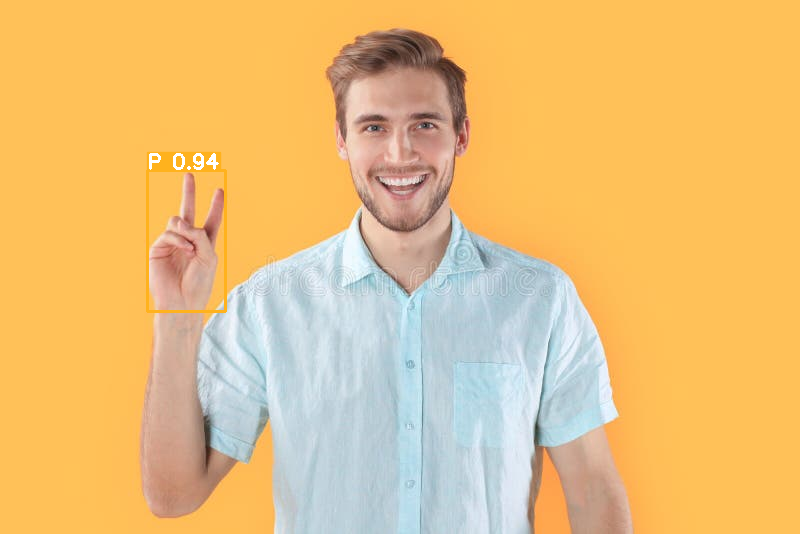

In [48]:
# IMG_SOURCE = "https://thumbs.dreamstime.com/b/young-man-showing-peace-sign-isolated-over-yellow-background-133210696.jpg"
IMG_SOURCE = "./young-man-showing-peace-sign-isolated-over-yellow-background-133210696.jpg"
# IMG_SOURCE = "Your_photo.jpg" # local file

print(f"Runing inference on: {IMG_SOURCE}")

# predict 
results = model.predict(IMG_SOURCE, verbose=False, half=False)
result = results[0] 

print("Result print = ",result.boxes) 

# extract detections 
detections = [] 
if result.boxes is not None:
    for i, cls_id in enumerate(result.boxes.cls.tolist()):
        name = result.names[int(cls_id)]
        conf = result.boxes.conf[i].item()
        detections.append({"gesture": name, "confidence": conf})

# print results 
print(f"\n Found {len(detections)} gesture(s): ")
for d in detections:
    print(f"{d['gesture']:20s} conf={d['confidence']:.3f}")
    pub.publish(d["gesture"], d["confidence"], len(detections))
    
# Render annotated image 
render = render_result(model=model, image=IMG_SOURCE, result=results[0])
display(render)

### run camera

In [ ]:
cap = cv2.VideoCapture(0)
log_output = widgets.Output()
display(log_output)

fps_time = time.time()
frame_count = 0

print(" Camera Started! Press 'q' to stop.")

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        
        # Inference (ใช้ imgsz=640 เพื่อความแม่นยำบน Nitro)
        results = model.predict(frame, conf=CONF, device=DEVICE, verbose=False, imgsz=640)
        result = results[0]
        
        frame_count += 1
        
        # Logic: Extract & MQTT Send
        if result.boxes is not None and len(result.boxes) > 0:
            best_box = result.boxes[0]
            label = result.names[int(best_box.cls[0])]
            conf = float(best_box.conf[0])
            
            if pub.publish(label, conf, len(result.boxes)):
                with log_output:
                    clear_output(wait=True)
                    print(f"MQTT Sent Log:")
                    for e in pub.log[-5:]: print(f"{e}")

        #  Visualization
        annotated = result.plot()
        fps = frame_count / (time.time() - fps_time)
        cv2.imshow("Test", annotated)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except Exception as e:
    print(f"Error: {e}")
finally:
    cap.release()
    cv2.destroyAllWindows()
    pub.CLI.loop_stop()
    pub.CLI.disconnect()
    print(f"System Closed. Total Pub: {pub.pub_count}")

Output()

 Camera Started! Press 'q' to stop.
System Closed. Total Pub: 140
